# comparison mb size 50 with 2, 4 cores in frequency minimum

# inicia os caminhos do notebook

In [1]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


# faz os imports e configuracoes que serao utilizadas

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format

# inicia os metodos de parser e auxiliares

In [3]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')

        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,x,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [4]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str and row["batch_size"] == 1:
            df.at[index, 'label'] = "Parallel"
        elif row["batch_size"] == 1:
            df.at[index, 'label'] = "Seq"
        else:
            df.at[index, 'label'] = row["batch_size"]
            
    return df

In [5]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [6]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [7]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [8]:
import natsort

#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    df.iloc[natsort.index_humansorted([df.label, df.batch_size])]

    labels = df.label
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [9]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(by=['batch_size']), alg)
           # df_aux = df_aux.sort_values(by=['label'], ascending=True)
#             if tables:
#                 display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

# resultados mb

### ler os resultados do mini-batching e coloca em um dataframe

In [10]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/mini-batching-medium/600/1200/first"
wantedCSVfilename = "data-batch-vs-acc-600-1200.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = add_label_column_df(df)
df = df.drop(['cores', 'time'], axis=1)
display(df)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_66362/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_66362/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_66362/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_66362/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,batch_size,x,instances,acc,prec,recall,change,label
0,elecNormNew,OBASHTRUNPER,25,1,1,"45,312.00",83.36,83.12,82.67,0.00,Parallel
1,airlines,OBMB,25,75,1,"539,383.00",65.02,65.85,62.68,0.00,75
2,covtypeNorm,SRPRUNPER,25,1,1,"63,130.00",93.08,87.61,87.40,0.00,Parallel
3,elecNormNew,OBMB,25,50,1,"45,312.00",78.77,78.41,77.88,0.00,50
4,airlines,OBMB,25,50,1,"539,383.00",65.05,65.89,62.70,0.00,50
5,GMSC,SRPSequential,25,1,1,"36,540.00",93.51,76.33,51.88,0.00,Seq
6,elecNormNew,LBagSequential,25,1,1,"45,312.00",89.85,89.85,89.31,280.00,Seq
7,elecNormNew,OBMB,25,75,1,"45,312.00",78.37,77.95,77.54,0.00,75
8,airlines,LBagSequential,25,1,1,"5,900.00",64.25,58.00,55.46,12.00,Seq
9,GMSC,OBASHTMB,25,100,1,"150,000.00",93.38,75.60,51.80,NaN,100


# seta novo caminho para os resultados de energia

In [11]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/coletor-energia/mini-batching-mediumbatches/first/'

In [12]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [13]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

In [14]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [15]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [16]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [17]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [18]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, bsize, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

In [19]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [20]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


# grafico em barras

### inicia os metodos para o grafico em barras, a funcao abaixo tambem ordena corretamente os resultados

In [33]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15

    df_mapping = pd.DataFrame({
        'label': ['MB', 'VFH2', 'VFH4', 'CL2', 'CL4', 'S'],
    })
    sort_mapping = df_mapping.reset_index().set_index('label')
    df['label_num'] = df['label'].map(sort_mapping['index'])

    df = df.drop_duplicates().sort_values('label_num')
    df = df[:-5]

    ##### reodenacao maluca
    df_sequential = df.loc[(df.label == "S")].reset_index()
    df_dvh2 = df.loc[(df.label == "VFH2")].reset_index()
    df_dvh4 = df.loc[(df.label == "VFH4")].reset_index()
    df_dvf2 = df.loc[(df.label == "CL2")].reset_index()
    df_dvf4 = df.loc[(df.label == "CL4")].reset_index()
    df_mb = df.loc[(df.label == "MB")].reset_index()

    df = pd.concat([df_sequential.head(1), df_dvh2.loc[1:1], df_dvh4.loc[2:2], 
                    df_dvf2.loc[3:3], df_dvf4.loc[2:2], df_mb.head(1)])
    ##### fim da reodenacao maluca
    
    
    alg_order = ['S', 'VFH2', 'VFH4', 'CL2', 'CL4', 'MB']
    labels = ['10%', '50%', '90%']
#     '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    line_format = [(0, (3, 10, 1, 10, 1, 10)), '-.', '--', (0, (1, 10)), 'dotted', '-']
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 6
    for i in range(versions):
        adf = df.iloc[i]

        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [24]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#         display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        # if len(showdf) != 5:
#         display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [25]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=3, bbox_to_anchor=(0.5, -0.10))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

In [26]:
def read_data_create_final_dataframe(freq, DEBUG=True):
    d = {}
    global header_printed
    header_printed = False
    if freq['cores'] != None:
        folder_path = f"{PATH_TO_RESULTS}{freq['cores']}/{freq['minimum']}/{freq['maximum']}"
    else:
        folder_path = f"{PATH_TO_RESULTS}{freq['minimum']}/{freq['maximum']}"
    min = freq['minimum']
    max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    finaldf['frequency_maximum'] = freq['maximum']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf-{min}x{max}.csv")    
    return tdf

In [34]:
## constroi os dataframes em arrays que serao utilizados abaixo

In [27]:
freqs = [{'minimum': '600', 'maximum': '1200', 'cores': None}]
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 288    mdf: 288     sshDF: 288


In [28]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

In [35]:
## seta novo caminho para os resultados com alteração de frequencia

In [29]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/coletor-energia/dpm/first/'

In [30]:
freqs = [
    {'minimum': '600', 'maximum': '600', 'cores': 2}, 
    {'minimum': '1200', 'maximum': '1200', 'cores': 2},
    {'minimum': '600', 'maximum': '600', 'cores': 4},
    {'minimum': '1200', 'maximum': '1200', 'cores': 4},
]

dataaframes_dvfs = []
for f in freqs:
    dataaframes_dvfs.append(read_data_create_final_dataframe(f, True))

# mergear o 0 com o 2 -> 600x600 2 cores e 600x600 4 cores
# mergear o 1 com o 3 -> 1200x1200 2 cores e 1200x1200 4 cores
dataframes_minimum_freq = pd.merge(dataaframes_dvfs[0], dataaframes_dvfs[2], how = 'outer')
dataframes_maximum_freq = pd.merge(dataaframes_dvfs[1], dataaframes_dvfs[3], how = 'outer')

# remove todas execucoes que nao sejam batch_size 50
df = dataframes[0]
df = df.drop(df[df.batch_size == 25].index)
df = df.drop(df[df.batch_size == 75].index)
df = df.drop(df[df.batch_size == 100].index)

# pega execução sequencial e bota em um novo dataframe
df_sequential = dataframes_maximum_freq.loc[(dataframes_maximum_freq.cores == 1) & (dataframes_maximum_freq.batch_size == 1)]

# remove todas execucoes sequenciais da frequencia minima
dataframes_minimum_freq = dataframes_minimum_freq.drop(dataframes_minimum_freq[dataframes_minimum_freq.algorithm.str.contains('Sequential') & (dataframes_maximum_freq.batch_size == 1)].index)
dataframes_minimum_freq = dataframes_minimum_freq.drop(dataframes_minimum_freq[(dataframes_minimum_freq.cores == 1) & (dataframes_minimum_freq.batch_size == 1)].index)

# remove todas execucoes sequenciais da frequencia maxima
dataframes_maximum_freq = dataframes_maximum_freq.drop(dataframes_maximum_freq[dataframes_maximum_freq.algorithm.str.contains('Sequential') & (dataframes_maximum_freq.batch_size == 1)].index)
dataframes_maximum_freq = dataframes_maximum_freq.drop(dataframes_maximum_freq[(dataframes_maximum_freq.cores == 1) & (dataframes_maximum_freq.batch_size == 1)].index)

# mergea a frequencia minima com mb e a frenquencia maxima com mb
dataframes_with_mb = pd.concat([df_sequential, df, dataframes_minimum_freq, dataframes_maximum_freq])



moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144
moaDF: 144    mdf: 144     sshDF: 144


In [31]:
def build_label(df):
    for index, row in df.iterrows():
        if ((row['algorithm'].find('Sequential') > 0 or row['batch_size'] == 1) and row['cores'] == 1):
            df.at[index, 'label'] = "S"

        if (row['cores'] == 4 and row['batch_size'] == 50):
            df.at[index, 'label'] = "MB"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 2 and row['frequency_maximum'] == "600"):
            df.at[index, 'label'] = "VFH2"
            
        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 4 and row['frequency_maximum'] == "600"):
            df.at[index, 'label'] = "VFH4"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 2 and row['frequency_maximum'] == "1200"):
            df.at[index, 'label'] = "CL2"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 4 and row['frequency_maximum'] == "1200"):
            df.at[index, 'label'] = "CL4"

    return df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


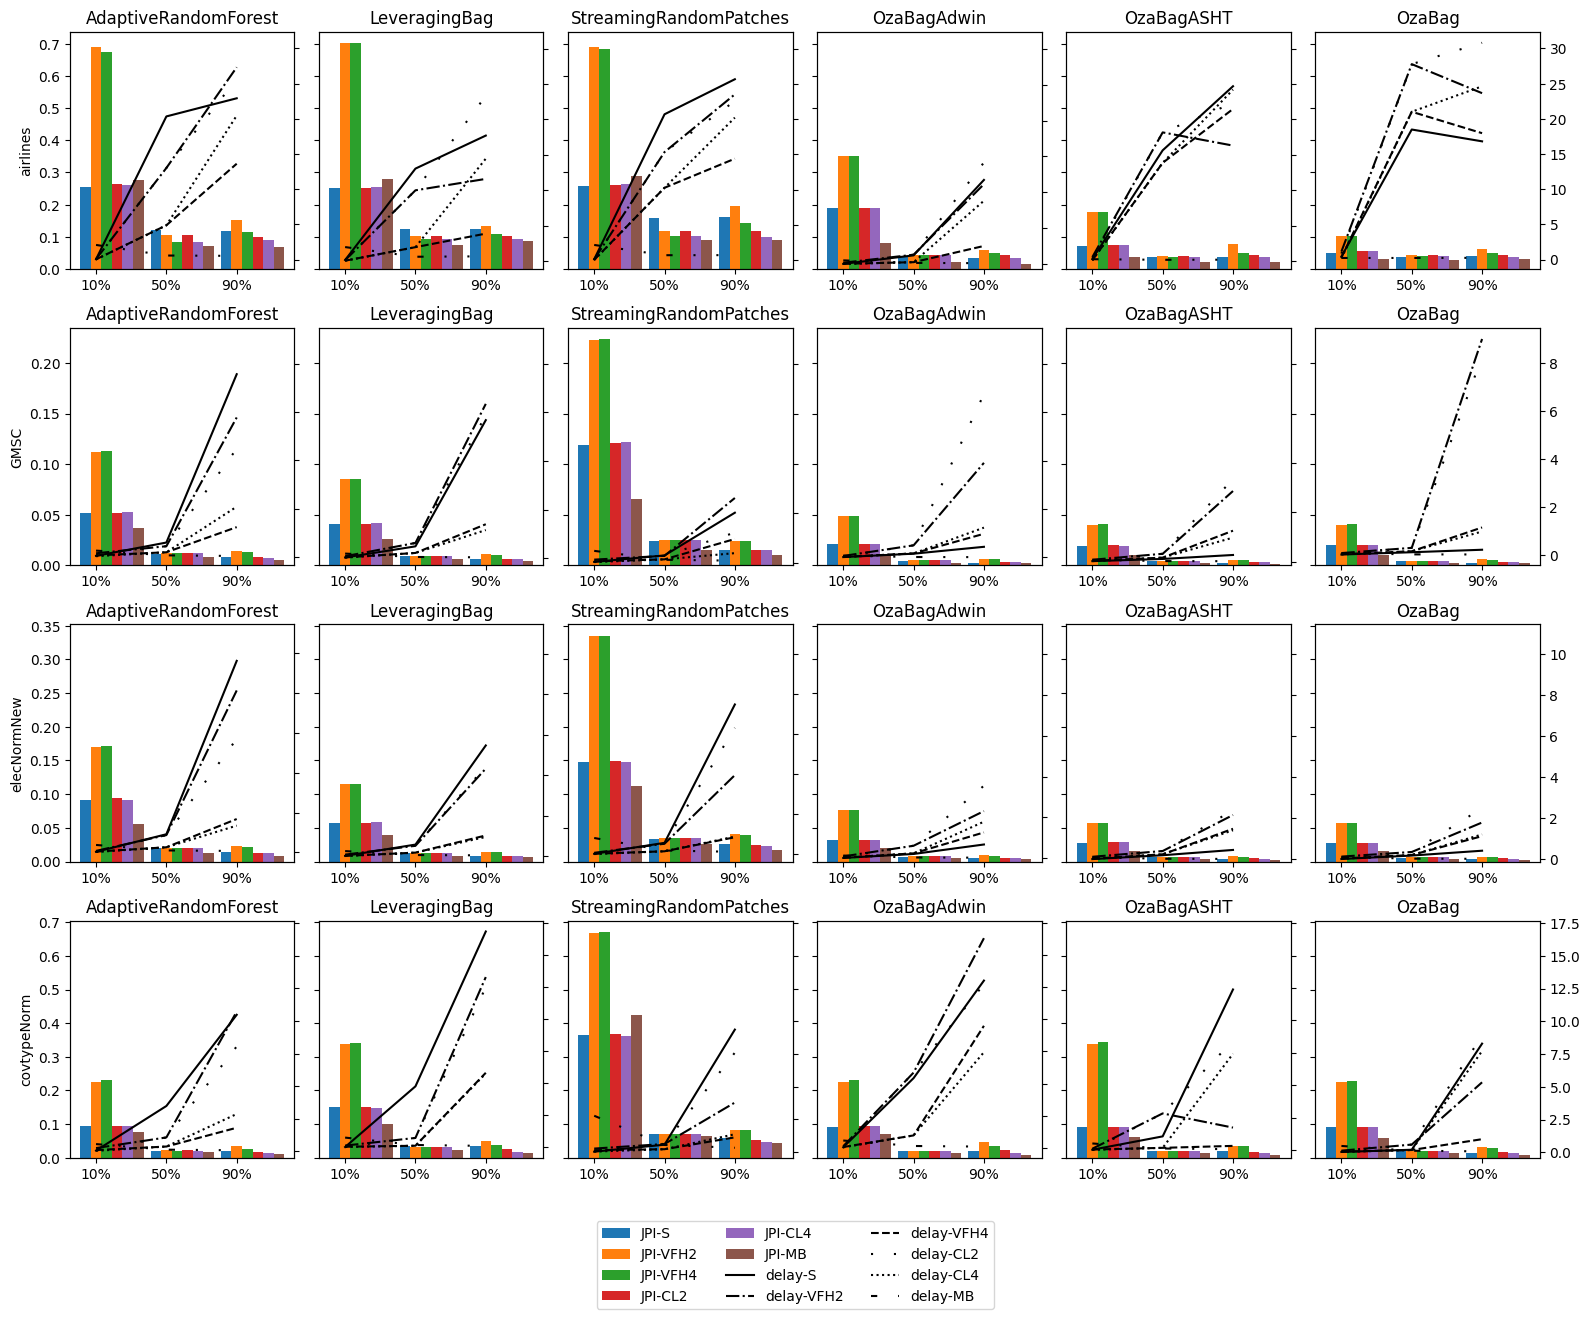

In [32]:
df2 = dataframes_with_mb
df2 = select_columns_and_rename_values_basic(df2)

df2 = build_label(df2.reset_index())

gen_graph(df2, bars=True, freq=f"{f['minimum']}x{f['maximum']}")

In [35]:
def gen_graph_joules(df_minimum, df_maximum, execution='first', only_eficiency=False):
    filename = f"pi-rates"
    fig, axs = plt.subplots(4, 6, figsize=(24, 10))
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    for ds in datasets:
        current_df = df_minimum[(df_minimum.dataset == ds)]
#         current_df_max = df_maximum[(df_maximum.dataset == ds)]

        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:            
            dfalg = build_label(
                filter_by_substring_algorithm(
                    current_df.reset_index(), alg
                )
            )

            df_mapping = pd.DataFrame({
                'label': ['S', 'VFH2', 'VFH4', 'CL2', 'CL4', 'MB'],
            })
            sort_mapping = df_mapping.reset_index().set_index('label')
            dfalg['label_num'] = dfalg['label'].map(sort_mapping['index'])

            dfalg = dfalg.drop_duplicates().sort_values('label_num')


#             dfalg = dfalg.iloc[:-1 , :] # remove duplicidade sequencial
            dfalg = dfalg.iloc[1: , :] # remove duplicidade sequencial

            display(dfalg)           
            my_id = algorithms.index(alg)
            
            c1 = 'tab:red'
            c2 = 'tab:blue'
            
            labels = dfalg.label
            x = np.arange(len(labels))
            alg_order = algorithms.index(alg)
            
            ax = axs[int(my_id_ds)][my_id%6]
            ax.plot(x, pd.to_numeric(dfalg.JPI), color=c1, linewidth=0.75, label='JPI')
            ax.tick_params(axis='y', labelcolor=c1)

            ax2 = ax.twinx()
            ax2.plot(x, pd.to_numeric(dfalg.IPS), color=c2, linewidth=0.7, label='IPS')
            ax2.tick_params(axis='y', labelcolor=c2)
            
            ax.set_title(f'{alg}')
            
            #if its the first column, print Y-axis label
            if my_id%6 == 0:
                ax.set_ylabel(f'{ds}')

            #if its the last row, print the X-axis label
            if int(my_id/6) == 1:
                ax.set_xlabel('Cores')

            ax.set_xticks(x)
            ax.set_xticklabels(labels)

    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/6), bbox_to_anchor=(0.5,-0.1))

    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
#     plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

## graficos em linhas de jpi e ips

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_23884/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_23884/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_23884/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_23884/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
11,246,airlines,ARFSequential,1,68.46,"4,435.00",120.01,0.12,506.82,1,1200,36.95,S,0
23,105,airlines,ARFRUNPER,1,71.60,"2,968.00",120.01,0.15,434.84,2,600,24.73,VFH2,1
29,249,airlines,ARFRUNPER,1,69.15,"4,149.00",120.01,0.12,463.94,4,600,34.57,VFH4,2
35,105,airlines,ARFRUNPER,1,66.98,"5,760.00",120.00,0.10,548.48,2,1200,48.00,CL2,3
41,249,airlines,ARFRUNPER,1,65.97,"6,644.00",120.00,0.09,570.70,4,1200,55.37,CL4,4
17,199,airlines,ARF,50,65.95,"11,250.00",120.20,0.07,726.39,4,1200,93.59,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
10,240,airlines,LBagSequential,1,66.97,"4,344.00",120.08,0.12,515.32,1,1200,36.17,S,0
22,99,airlines,LBagRUNPER,1,69.16,"3,560.00",120.01,0.13,439.44,2,600,29.66,VFH2,1
28,243,airlines,LBagRUNPER,1,66.20,"4,731.00",120.03,0.11,480.72,4,600,39.42,VFH4,2
34,99,airlines,LBagRUNPER,1,64.43,"5,892.00",120.01,0.10,571.43,2,1200,49.10,CL2,3
40,243,airlines,LBagRUNPER,1,63.06,"7,141.00",120.00,0.09,641.35,4,1200,59.51,CL4,4
16,166,airlines,LBag,50,61.81,"9,300.00",120.34,0.09,771.53,4,1200,77.28,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
6,219,airlines,SRPSequential,1,71.84,"3,214.00",120.00,0.16,501.55,1,1200,26.78,S,0
18,72,airlines,SRPRUNPER,1,74.06,"2,325.00",120.03,0.19,430.25,2,600,19.37,VFH2,1
24,216,airlines,SRPRUNPER,1,71.78,"3,349.00",120.01,0.14,455.34,4,600,27.91,VFH4,2
30,72,airlines,SRPRUNPER,1,68.60,"4,739.00",120.00,0.12,546.85,2,1200,39.49,CL2,3
36,216,airlines,SRPRUNPER,1,66.78,"6,270.00",120.01,0.10,606.87,4,1200,52.25,CL4,4
12,94,airlines,SRPSequential,50,65.52,"8,250.00",120.27,0.09,730.10,4,1200,68.60,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
7,228,airlines,OBAdwinSequential,1,63.41,"15,116.00",120.01,0.04,516.40,1,1200,125.96,S,0
20,81,airlines,OBAdwinRUNPER,1,65.21,"7,631.00",120.00,0.06,432.84,2,600,63.59,VFH2,1
26,225,airlines,OBAdwinRUNPER,1,64.30,"9,687.00",120.05,0.05,456.35,4,600,80.69,VFH4,2
32,81,airlines,OBAdwinRUNPER,1,63.86,"13,422.00",120.01,0.04,548.22,2,1200,111.84,CL2,3
38,225,airlines,OBAdwinRUNPER,1,63.28,"17,307.00",120.03,0.04,593.93,4,1200,144.19,CL4,4
14,73,airlines,OBAdwinSequential,50,68.65,"46,150.00",120.06,0.02,727.59,4,1200,384.40,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
8,234,airlines,OBASHTSequential,1,63.87,"14,770.00",120.00,0.04,509.50,1,1200,123.08,S,0
21,87,airlines,OBASHTRUNPER,1,66.16,"5,800.00",120.00,0.08,426.58,2,600,48.33,VFH2,1
27,231,airlines,OBASHTRUNPER,1,63.43,"9,746.00",120.03,0.05,459.14,4,600,81.20,VFH4,2
33,87,airlines,OBASHTRUNPER,1,62.88,"13,335.00",120.00,0.04,551.41,2,1200,111.12,CL2,3
39,231,airlines,OBASHTRUNPER,1,62.77,"16,674.00",120.00,0.04,597.42,4,1200,138.94,CL4,4
15,46,airlines,OBASHTSequential,50,67.76,"34,300.00",121.91,0.02,754.53,4,1200,281.36,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
9,237,airlines,OBSequential,1,64.75,"13,000.00",120.00,0.04,516.29,1,1200,108.33,S,0
19,78,airlines,OBRUNPER,1,63.90,"7,474.00",120.06,0.06,439.94,2,600,62.25,VFH2,1
25,222,airlines,OBRUNPER,1,63.14,"10,025.00",120.01,0.05,464.69,4,600,83.53,VFH4,2
31,78,airlines,OBRUNPER,1,65.00,"13,790.00",120.00,0.04,554.01,2,1200,114.91,CL2,3
37,222,airlines,OBRUNPER,1,61.68,"16,656.00",120.62,0.04,613.97,4,1200,138.08,CL4,4
13,223,airlines,OBSequential,50,66.19,"24,700.00",120.98,0.03,763.18,4,1200,204.16,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
11,282,GMSC,ARFSequential,1,93.41,"60,885.00",120.00,0.01,499.07,1,1200,507.37,S,0
23,141,GMSC,ARFRUNPER,1,93.46,"33,392.00",120.00,0.01,435.20,2,600,278.26,VFH2,1
29,285,GMSC,ARFRUNPER,1,93.46,"34,143.00",119.99,0.01,439.01,4,600,284.54,VFH4,2
35,141,GMSC,ARFRUNPER,1,93.45,"69,123.00",120.00,0.01,536.73,2,1200,576.02,CL2,3
41,285,GMSC,ARFRUNPER,1,93.44,"74,744.00",120.00,0.01,556.14,4,1200,622.85,CL4,4
17,209,GMSC,ARF,50,93.53,"119,600.00",119.96,0.01,624.51,4,1200,996.97,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
10,276,GMSC,LBagSequential,1,93.48,"84,386.00",120.00,0.01,496.58,1,1200,703.21,S,0
22,135,GMSC,LBagRUNPER,1,93.37,"41,746.00",120.01,0.01,428.53,2,600,347.86,VFH2,1
28,279,GMSC,LBagRUNPER,1,93.39,"43,701.00",120.00,0.01,431.74,4,600,364.17,VFH4,2
34,135,GMSC,LBagRUNPER,1,93.50,"85,387.00",120.42,0.01,535.12,2,1200,709.09,CL2,3
40,279,GMSC,LBagRUNPER,1,93.50,"96,785.00",120.00,0.01,538.37,4,1200,806.53,CL4,4
16,262,GMSC,LBag,50,93.34,"150,000.00",107.18,0.00,561.66,4,1200,"1,399.55",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
6,255,GMSC,SRPSequential,1,93.51,"35,679.00",120.01,0.01,508.27,1,1200,297.31,S,0
18,108,GMSC,SRPRUNPER,1,93.58,"18,570.00",120.01,0.02,428.09,2,600,154.74,VFH2,1
24,252,GMSC,SRPRUNPER,1,93.58,"18,569.00",119.94,0.02,430.59,4,600,154.81,VFH4,2
30,108,GMSC,SRPRUNPER,1,93.51,"35,936.00",120.00,0.02,525.40,2,1200,299.46,CL2,3
36,252,GMSC,SRPRUNPER,1,93.51,"35,938.00",120.00,0.01,515.85,4,1200,299.48,CL4,4
12,36,GMSC,SRPSequential,50,93.43,"68,250.00",120.03,0.01,653.70,4,1200,568.60,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
7,264,GMSC,OBAdwinSequential,1,93.45,"150,000.00",95.52,0.00,389.37,1,1200,"1,570.34",S,0
20,117,GMSC,OBAdwinRUNPER,1,93.48,"76,664.00",120.00,0.01,426.62,2,600,638.86,VFH2,1
26,261,GMSC,OBAdwinRUNPER,1,93.45,"77,812.00",120.00,0.01,425.38,4,600,648.43,VFH4,2
32,117,GMSC,OBAdwinRUNPER,1,93.52,"146,124.00",113.01,0.00,501.25,2,1200,"1,293.06",CL2,3
38,261,GMSC,OBAdwinRUNPER,1,93.52,"149,599.00",95.56,0.00,438.42,4,1200,"1,565.55",CL4,4
14,127,GMSC,OBAdwinSequential,50,93.33,"149,259.00",45.95,0.00,238.96,4,1200,"3,248.01",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
8,270,GMSC,OBASHTSequential,1,93.33,"150,000.00",87.14,0.00,350.27,1,1200,"1,721.31",S,0
21,123,GMSC,OBASHTRUNPER,1,93.41,"92,628.00",120.01,0.00,423.55,2,600,771.84,VFH2,1
27,267,GMSC,OBASHTRUNPER,1,93.41,"95,681.00",120.00,0.00,432.73,4,600,797.34,VFH4,2
33,123,GMSC,OBASHTRUNPER,1,93.38,"145,344.00",91.82,0.00,401.37,2,1200,"1,582.91",CL2,3
39,267,GMSC,OBASHTRUNPER,1,93.41,"149,486.00",87.21,0.00,393.82,4,1200,"1,714.03",CL4,4
15,54,GMSC,OBASHTSequential,50,93.36,"150,000.00",41.10,0.00,207.30,4,1200,"3,649.90",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
9,273,GMSC,OBSequential,1,93.45,"150,000.00",90.55,0.00,362.00,1,1200,"1,656.49",S,0
19,114,GMSC,OBRUNPER,1,93.44,"71,929.00",120.01,0.01,429.95,2,600,599.38,VFH2,1
25,258,GMSC,OBRUNPER,1,93.49,"93,895.00",120.00,0.00,432.97,4,600,782.45,VFH4,2
31,114,GMSC,OBRUNPER,1,93.54,"146,719.00",115.21,0.00,513.42,2,1200,"1,273.49",CL2,3
37,258,GMSC,OBRUNPER,1,93.56,"149,673.00",90.65,0.00,407.35,4,1200,"1,651.11",CL4,4
13,113,GMSC,OBSequential,50,93.39,"149,625.00",49.43,0.00,257.42,4,1200,"3,027.19",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
11,174,elecNormNew,ARFSequential,1,88.56,"36,321.00",120.00,0.01,509.90,1,1200,302.67,S,0
23,33,elecNormNew,ARFRUNPER,1,89.74,"19,945.00",120.00,0.02,435.23,2,600,166.21,VFH2,1
29,177,elecNormNew,ARFRUNPER,1,89.58,"21,564.00",119.95,0.02,445.91,4,600,179.78,VFH4,2
35,33,elecNormNew,ARFRUNPER,1,88.59,"43,873.00",120.00,0.01,549.88,2,1200,365.60,CL2,3
41,177,elecNormNew,ARFRUNPER,1,88.77,"45,312.00",114.99,0.01,533.90,4,1200,394.05,CL4,4
17,128,elecNormNew,ARF,50,80.72,"43,654.00",65.86,0.01,367.45,4,1200,662.88,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
10,168,elecNormNew,LBagSequential,1,89.78,"44,200.00",86.10,0.01,363.77,1,1200,513.36,S,0
22,27,elecNormNew,LBagRUNPER,1,89.61,"32,220.00",120.01,0.01,431.39,2,600,268.48,VFH2,1
28,171,elecNormNew,LBagRUNPER,1,89.91,"32,945.00",119.97,0.01,429.78,4,600,274.60,VFH4,2
34,27,elecNormNew,LBagRUNPER,1,89.83,"43,680.00",79.87,0.01,355.48,2,1200,546.92,CL2,3
40,171,elecNormNew,LBagRUNPER,1,89.96,"44,761.00",73.27,0.01,333.34,4,1200,610.89,CL4,4
16,219,elecNormNew,LBag,50,81.39,"42,962.00",44.80,0.01,249.47,4,1200,958.91,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
6,147,elecNormNew,SRPSequential,1,91.33,"20,695.00",120.00,0.03,511.34,1,1200,172.46,S,0
18,0,elecNormNew,SRPRUNPER,1,91.50,"11,382.00",120.01,0.04,435.87,2,600,94.84,VFH2,1
24,144,elecNormNew,SRPRUNPER,1,91.50,"11,382.00",120.01,0.04,432.35,4,600,94.84,VFH4,2
30,0,elecNormNew,SRPRUNPER,1,90.66,"23,395.00",120.00,0.02,553.29,2,1200,194.95,CL2,3
36,144,elecNormNew,SRPRUNPER,1,90.27,"26,955.00",119.97,0.02,582.77,4,1200,224.68,CL4,4
12,31,elecNormNew,SRPSequential,50,80.95,"41,930.00",119.95,0.02,703.87,4,1200,349.55,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
7,156,elecNormNew,OBAdwinSequential,1,84.45,"45,068.00",43.92,0.00,184.12,1,1200,"1,026.14",S,0
20,9,elecNormNew,OBAdwinRUNPER,1,85.88,"42,813.00",103.17,0.01,362.38,2,600,414.97,VFH2,1
26,153,elecNormNew,OBAdwinRUNPER,1,86.13,"45,238.00",103.18,0.01,365.34,4,600,438.42,VFH4,2
32,9,elecNormNew,OBAdwinRUNPER,1,86.11,"42,041.00",49.81,0.01,217.82,2,1200,844.06,CL2,3
38,153,elecNormNew,OBAdwinRUNPER,1,86.37,"44,255.00",43.91,0.01,203.96,4,1200,"1,007.79",CL4,4
14,132,elecNormNew,OBAdwinSequential,50,79.48,"42,484.00",23.52,0.00,122.34,4,1200,"1,806.45",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
8,162,elecNormNew,OBASHTSequential,1,83.28,"44,672.00",37.55,0.00,155.71,1,1200,"1,189.54",S,0
21,15,elecNormNew,OBASHTRUNPER,1,83.99,"41,844.00",81.87,0.01,285.89,2,600,511.11,VFH2,1
27,159,elecNormNew,OBASHTRUNPER,1,82.97,"44,786.00",81.86,0.01,291.99,4,600,547.07,VFH4,2
33,15,elecNormNew,OBASHTRUNPER,1,83.99,"41,021.00",39.06,0.00,171.53,2,1200,"1,050.23",CL2,3
39,159,elecNormNew,OBASHTRUNPER,1,84.05,"44,185.00",37.60,0.00,174.26,4,1200,"1,175.07",CL4,4
15,66,elecNormNew,OBASHTSequential,50,79.37,"43,758.00",19.06,0.00,96.11,4,1200,"2,295.92",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
9,165,elecNormNew,OBSequential,1,81.67,"44,432.00",36.39,0.00,148.30,1,1200,"1,220.99",S,0
19,6,elecNormNew,OBRUNPER,1,83.03,"42,000.00",79.03,0.01,276.67,2,600,531.42,VFH2,1
25,150,elecNormNew,OBRUNPER,1,82.39,"44,950.00",79.05,0.01,284.29,4,600,568.62,VFH4,2
31,6,elecNormNew,OBRUNPER,1,82.47,"40,776.00",38.41,0.00,168.92,2,1200,"1,061.52",CL2,3
37,150,elecNormNew,OBRUNPER,1,83.01,"43,639.00",36.42,0.00,168.71,4,1200,"1,198.35",CL4,4
13,14,elecNormNew,OBSequential,50,78.67,"43,510.00",19.58,0.00,100.31,4,1200,"2,222.73",MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
11,210,covtypeNorm,ARFSequential,1,81.49,"26,671.00",120.00,0.02,498.42,1,1200,222.25,S,0
23,69,covtypeNorm,ARFRUNPER,1,73.67,"12,864.00",120.02,0.03,429.57,2,600,107.18,VFH2,1
29,213,covtypeNorm,ARFRUNPER,1,75.95,"17,481.00",119.93,0.03,439.39,4,600,145.76,VFH4,2
35,69,covtypeNorm,ARFRUNPER,1,84.01,"34,302.00",120.00,0.02,533.82,2,1200,285.85,CL2,3
41,213,covtypeNorm,ARFRUNPER,1,85.94,"42,105.00",120.00,0.01,547.99,4,1200,350.87,CL4,4
17,185,covtypeNorm,ARF,50,86.23,"62,100.00",120.05,0.01,625.49,4,1200,517.28,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
10,204,covtypeNorm,LBagSequential,1,74.07,"15,424.00",120.01,0.03,493.90,1,1200,128.53,S,0
22,63,covtypeNorm,LBagRUNPER,1,73.21,"9,413.00",120.04,0.05,427.02,2,600,78.42,VFH2,1
28,207,covtypeNorm,LBagRUNPER,1,74.62,"12,283.00",120.01,0.04,444.39,4,600,102.35,VFH4,2
34,63,covtypeNorm,LBagRUNPER,1,78.61,"21,051.00",120.00,0.03,525.31,2,1200,175.42,CL2,3
40,207,covtypeNorm,LBagRUNPER,1,83.31,"31,128.00",120.00,0.02,549.40,4,1200,259.40,CL4,4
16,61,covtypeNorm,LBag,50,85.43,"47,900.00",120.02,0.01,600.83,4,1200,399.11,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
6,183,covtypeNorm,SRPSequential,1,82.06,"8,934.00",120.00,0.06,501.39,1,1200,74.45,S,0
18,36,covtypeNorm,SRPRUNPER,1,82.40,"5,382.00",120.00,0.08,426.90,2,600,44.85,VFH2,1
24,180,covtypeNorm,SRPRUNPER,1,82.37,"5,383.00",120.00,0.08,432.49,4,600,44.86,VFH4,2
30,36,covtypeNorm,SRPRUNPER,1,81.81,"10,333.00",120.01,0.05,532.25,2,1200,86.10,CL2,3
36,180,covtypeNorm,SRPRUNPER,1,81.42,"12,435.00",120.00,0.05,560.49,4,1200,103.62,CL4,4
12,32,covtypeNorm,SRPSequential,50,75.44,"14,975.00",119.94,0.04,628.32,4,1200,124.85,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
7,192,covtypeNorm,OBAdwinSequential,1,76.82,"23,513.00",120.00,0.02,481.32,1,1200,195.94,S,0
20,45,covtypeNorm,OBAdwinRUNPER,1,74.62,"9,646.00",120.01,0.05,422.56,2,600,80.38,VFH2,1
26,189,covtypeNorm,OBAdwinRUNPER,1,74.32,"13,063.00",120.00,0.04,440.35,4,600,108.86,VFH4,2
32,45,covtypeNorm,OBAdwinRUNPER,1,80.07,"23,720.00",120.00,0.02,516.53,2,1200,197.67,CL2,3
38,189,covtypeNorm,OBAdwinRUNPER,1,81.04,"37,362.00",120.00,0.02,543.58,4,1200,311.35,CL4,4
14,121,covtypeNorm,OBAdwinSequential,50,83.41,"66,150.00",120.01,0.01,576.38,4,1200,551.19,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
8,198,covtypeNorm,OBASHTSequential,1,71.07,"23,342.00",120.00,0.02,478.22,1,1200,194.52,S,0
21,51,covtypeNorm,OBASHTRUNPER,1,64.58,"12,542.00",120.00,0.04,417.77,2,600,104.51,VFH2,1
27,195,covtypeNorm,OBASHTRUNPER,1,64.62,"12,579.00",119.93,0.04,422.18,4,600,104.88,VFH4,2
33,51,covtypeNorm,OBASHTRUNPER,1,75.91,"32,650.00",120.00,0.02,512.22,2,1200,272.08,CL2,3
39,195,covtypeNorm,OBASHTRUNPER,1,75.81,"36,904.00",120.00,0.01,528.38,4,1200,307.53,CL4,4
15,33,covtypeNorm,OBASHTSequential,50,81.67,"74,350.00",120.01,0.01,558.31,4,1200,619.54,MB,5


,index,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,frequency_maximum,IPS,label,label_num
9,201,covtypeNorm,OBSequential,1,73.15,"32,605.00",120.00,0.02,480.85,1,1200,271.70,S,0
19,42,covtypeNorm,OBRUNPER,1,64.89,"13,826.00",120.01,0.03,422.50,2,600,115.21,VFH2,1
25,186,covtypeNorm,OBRUNPER,1,66.27,"15,727.00",120.00,0.03,431.90,4,600,131.06,VFH4,2
31,42,covtypeNorm,OBRUNPER,1,75.12,"31,484.00",120.00,0.02,510.80,2,1200,262.36,CL2,3
37,186,covtypeNorm,OBRUNPER,1,75.04,"36,178.00",120.00,0.02,529.11,4,1200,301.48,CL4,4
13,37,covtypeNorm,OBSequential,50,81.89,"77,200.00",120.03,0.01,559.20,4,1200,643.20,MB,5


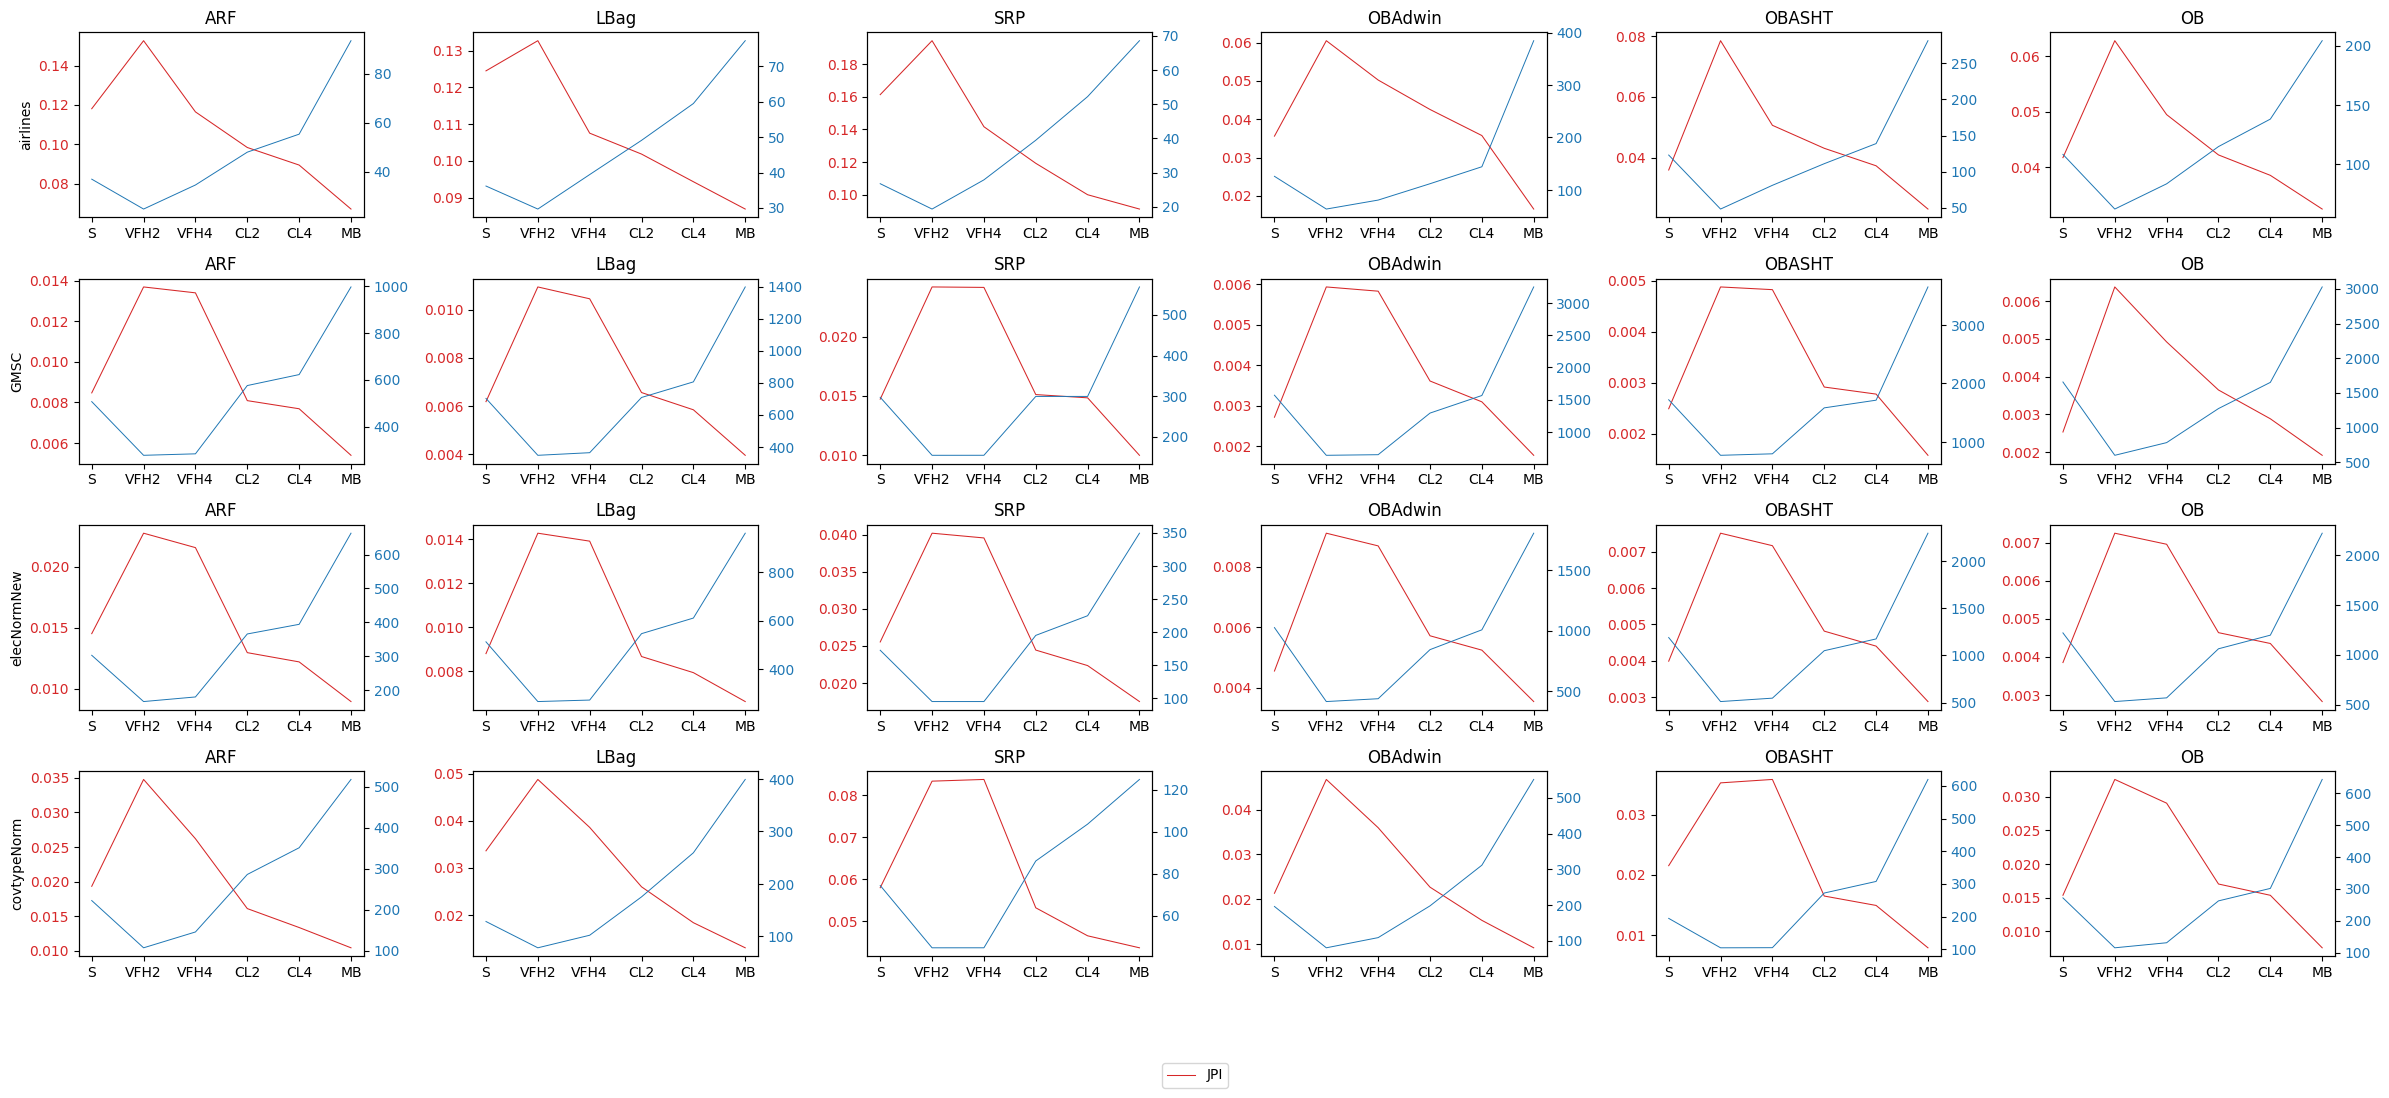

In [36]:
df = dataframes_with_mb
df = df[df.PERC == '90']

df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'frequency_maximum']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

gen_graph_joules(df, None)

Beforehand, it is necessary to analyse in detail the for minimum frequency. The figure X show in details JPI consumer by execution and IPS are 24 executions with 4 datasets diffentes and four methods differents. In MB are executions with mini-batching, PLR-2 and PLR-4 are executions parallels with respective cores and finally, SEQ represent sequential execution, in other words, original MOA implementation.

A trend can be observed with all experiments. First execution MB had low consumer JPI and high consumer IPS and then JPI is increased with 2 cores and decrease 4 cores, after increased again in SEQ, while IPS trend a decrease. But is visible the experiments parallel with minimum frequency is better result in JPI and IPS that original implementation SEQ.

Is necessary, we also see the results to maximum frequency. In same figure we can see this data, firstly same similar trend with JPI and IPS. Increase JPI when used PLR-2 and PLR-4, after more JPI in sequential and IPS decrease in all experiments. The main change is values absolutes. If we look to the dasheds lines can be results with maximum frequency, a trend of decrease IPS and increase JPI is visible, but when compared in JPI can see maximum frequency consume minus JPI and more IPS in all scenaries.

This can yield a result that is different from what you intended as it with minimum frequency we should consume minus energy, but the instructions in CPU also reduce and in this way reduce performance in IPS consequently JPI be major.